In [13]:
from transformers import GPT2LMHeadModel

In [14]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2') #124M model

In [15]:
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    if k.endswith('attn.bias'):
        print(k, v.shape)


transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.2.attn.c_attn.bias torch.Size([2304])
transformer.h.3.attn.c_attn.bias torch.Size([2304])
transformer.h.4.attn.c_attn.bias torch.Size([2304])
transformer.h.5.attn.c_attn.bias torch.Size([2304])
transformer.h.6.attn.c_attn.bias torch.Size([2304])
transformer.h.7.attn.c_attn.bias torch.Size([2304])
transformer.h.8.attn.c_attn.bias torch.Size([2304])
transformer.h.9.attn.c_attn.bias torch.Size([2304])
transformer.h.10.attn.c_attn.bias torch.Size([2304])
transformer.h.11.attn.c_attn.bias torch.Size([2304])


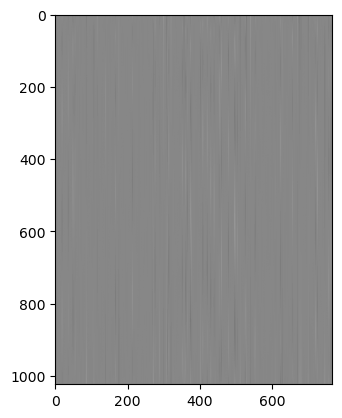

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf['transformer.wpe.weight'], cmap='gray')

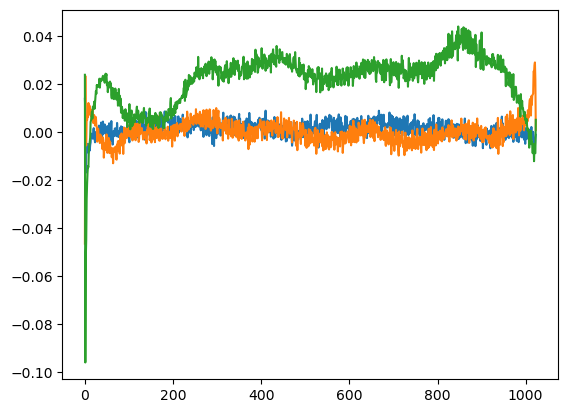

In [14]:
plt.plot(sd_hf['transformer.wpe.weight'][:,100])
plt.plot(sd_hf['transformer.wpe.weight'][:,150])
plt.plot(sd_hf['transformer.wpe.weight'][:,250])

In [15]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]

In [4]:
import torch
from torch.nn import functional as F
device = (
            'cuda' if torch.cuda.is_available()
            else 'mps' if torch.backends.mps.is_available()
            else 'cpu'
          )
print(f"{device=}")



num_return_sequences =  5
max_length = 30

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
model.to(device)

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) #(5,8)
# print(tokens)
x = tokens.to(device)

# generate! x is (B,T) B=5 T=8
#set seed to 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    with torch.no_grad():
        # forward the model to get logits
        logits = model(x)[0]
        # get last logits for each batch
        logits = logits[:,-1,:] #(B, vocab_size)
        # get the probabilites via softmax
        probs = F.softmax(logits, dim=-1)
        # do topk sampling to get top 50 (default from HF)
        # topk_probs and topk_indices both (5,50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from topk
        ix = torch.multinomial(topk_probs, 1) # (B,1)
        # get corresponding indices
        xcol = torch.gather(topk_indices, -1, ix)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

    
# print generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

device='mps'
> Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
> Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
> Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
> Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
> Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because


In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-06-14 14:18:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2024-06-14 14:18:31 (8.57 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [7]:
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens)

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13, 198, 198, 5962, 22307, 25, 198, 1639, 389, 477, 12939, 2138, 284, 4656, 621, 284, 1145, 680, 30, 198, 198, 3237, 25, 198, 4965, 5634, 13, 12939, 13, 198, 198, 5962, 22307, 25, 198, 5962, 11, 345, 760, 327, 1872, 385, 1526, 28599, 318, 4039, 4472, 284, 262, 661, 13, 198, 198, 3237, 25, 198, 1135, 760, 470, 11, 356, 760, 470, 13, 198, 198, 5962, 22307, 25, 198, 5756, 514, 1494, 683, 11, 290, 356, 1183, 423, 11676, 379, 674, 898, 2756, 13, 198, 3792, 470, 257, 15593, 30, 198, 198, 3237, 25, 198, 2949, 517, 3375, 319, 470, 26, 1309, 340, 307, 1760, 25, 1497, 11, 1497, 0, 198, 198, 12211, 22307, 25, 198, 3198, 1573, 11, 922, 4290, 13, 198, 198, 5962, 22307, 25, 198, 1135, 389, 17830, 3595, 4290, 11, 262, 1458, 1173, 1547, 922, 13, 198, 2061, 4934, 969, 5036, 896, 319, 561, 26958, 514, 25, 611, 484, 198, 19188, 7800, 514, 475, 262, 48713, 414, 11, 981, 340, 547, 198, 

In [11]:
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4,6)
targets = buf[1:].view(4,6)
print(x)
print(targets)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [17]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [18]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

In [19]:
print(sd_hf["transformer.wte.weight"].data_ptr())
print(sd_hf["lm_head.weight"].data_ptr())

12173115392
12173115392


In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))